## Machine Learning applied to identify Active Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the Activity model.

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

%matplotlib inline

In [2]:
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1

In [4]:
meta_data = pd.read_excel('../data/Cumulative_Peptide_data_v04_PG1.xlsx', index_col=0)
meta_data['MBC'] = [convert_mic(x) for x in meta_data['MBC']]
meta_data

,ID,Sequence,MBC,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069
...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367
92,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085
93,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292
94,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276


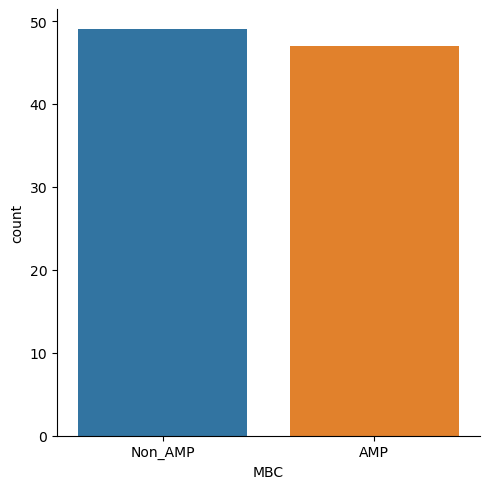

In [5]:
sns.catplot(data=meta_data, x='MBC', kind='count')
plt.xticks([0,1], ['Non_AMP', 'AMP'])
plt.show()

## Define the Model

In [ ]:
np.random.seed(42)

results_df = pd.DataFrame()

base_dir = '/stor/work/Wilke/luiz/ML/embeddingsNew/embeds_PG1_v04/'
#folders = ['bepler/', 'plusRNN/', 'protAlbert/', 'protBert/', 'secVec/', 'esm1b/', 'esm2_650M/', 'esm2_3B/']
folders = ['esm2_15B/']


for dir in folders:
    dir_path = base_dir+dir
    meta_data = pd.read_excel('../data/Cumulative_Peptide_data_v04_PG1.xlsx', usecols=['ID', 'Sequence', 'MBC'])
    embeddings = {}

    if dir == 'esm1b/':
        for file in os.listdir(dir_path):
            file_path = str(dir_path) + file 
            label = file.split('.pt')[0]
            embeddings[label] = np.array(torch.load(file_path)['mean_representations'][33])
    
    elif dir == 'esm2_650M/':
        for file in os.listdir(dir_path):
            file_path = str(dir_path) + file 
            label = file.split('.pt')[0]
            embeddings[label] = np.array(torch.load(file_path)['mean_representations'][33])

    elif dir == 'esm2_3B/':
        for file in os.listdir(dir_path):
            file_path = str(dir_path) + file 
            label = file.split('.pt')[0]
            embeddings[label] = np.array(torch.load(file_path)['mean_representations'][36])

    elif dir == 'esm2_15B/':
        for file in os.listdir(dir_path):
            file_path = str(dir_path) + file 
            label = file.split('.pt')[0]
            embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])
    else:
        for file in os.listdir(dir_path):
            file_path = str(dir_path) + file 
            label = file.split('.npy')[0]
            embeddings[label] = np.load(file_path)


    # here I creating a dictionary with ID as key and semantic value as value 
    data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

    # define target to evaluete the model
    target = [is_AMP(x) for x in data["MBC"]]
    features = data.iloc[:, 3:]

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # create a list of classifiers to test
    classifiers = [
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        GaussianNB(),
        SVC(),
        RandomForestClassifier()
    ]

    # create a dictionary of hyperparameters to search over for each classifier
    param_grids = [
        {'n_neighbors': [5, 10, 30, 50], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
        {'max_depth': [None, 2, 4, 6], 'min_samples_split': [2, 4, 6]},
        {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]},
        {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'max_iter': [-1], 'class_weight': [None, 'balanced']},
        {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 50], 'min_samples_split': [5, 10, 50], 'max_features': ['sqrt', 'log2']}
    ]

    # create a list of names for the classifiers for printing results
    model_names = ["KNN", "Decision Tree", 'GaussianNB', "SVM", 'RandomForest']
    features_names = ['None', 'selected_by_correlation', 'RandomForest_importance', 'DecissionTree_importance', 'Lasso_penalty']

    # loop over the classifiers and hyperparameter grids
    for name, clf, param_grid in zip(model_names, classifiers, param_grids):
        # create a GridSearchCV object with 5-fold cross-validation
        grid = GridSearchCV(clf, param_grid, cv=10)

        # fit the grid search object to the training data
        grid.fit(X_train, y_train)

        # make predictions on the test data using the best model found by the grid search
        y_pred = grid.best_estimator_.predict(X_test)
        best_score = str(grid.best_score_.round(2))

        # evaluate the performance of the best model on the test data using accuracy score
        accuracy = metrics.accuracy_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        f1_score = metrics.f1_score(y_test, y_pred)
        
        print(f'Accuracy: {accuracy.round(2)}, Recall: {recall.round(2)}, Precision: {precision.round(2)}')
        # Saving results
        res_dict = {}
        embed_name = dir[:-1]
        res_dict["embedding"] = embed_name
        res_dict["embed_size"] = features.shape[1]
        res_dict["model"] = name
        res_dict["Accuracy"] = accuracy.round(2)
        res_dict["recall"] = recall.round(2)
        res_dict["precision"] = precision.round(2)
        res_dict["f1"] = f1_score.round(2)
        res_dict["train_mean_10cv"] = best_score
        res_dict['best_params'] = str(grid.best_params_)

     
        # updating data frame with results
        results_df = pd.concat([results_df, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)

        ########################### confusion_matrix ################################## 
        conf_m = metrics.confusion_matrix(y_test, y_pred)

        # Annotations parameters
        group_names = ['True Negative','False Positive','False Negative','True Positive']
        group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        # Heat map plot
        plt.figure(figsize=(8,6))
        ticks_labels = ['Non_AMP', 'AMP']
        sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", annot_kws={'size': 12}, 
                    yticklabels=ticks_labels, xticklabels=ticks_labels)
        plt.title(f'{name} Performance on {embed_name}', fontsize=18)
        plt.ylabel('Actual Label', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=16)
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        #plt.savefig(f'results_cls_esm2_15B/{embed_name}_{name}.jpeg')
        plt.close()
    

results_df#.to_excel('results_cls_esm2_15B/AMP_classification_best_results.xlsx')

## Vizualize results

In [2]:
results_df = pd.read_excel('results_cls_esm2_15B/AMP_classification_best_results.xlsx', index_col=0)
results_df

,embedding,embed_size,model,Accuracy,recall,precision,f1,train_mean_10cv,best_params
0,esm2_15B,5120,KNN,0.65,0.91,0.62,0.74,0.63,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
1,esm2_15B,5120,Decision Tree,0.85,0.73,1.00,0.84,0.61,"{'max_depth': None, 'min_samples_split': 2}"
2,esm2_15B,5120,GaussianNB,0.85,0.91,0.83,0.87,0.59,{'var_smoothing': 1e-09}
3,esm2_15B,5120,SVM,0.90,0.91,0.91,0.91,0.66,"{'C': 100, 'class_weight': 'balanced', 'gamma'..."
4,esm2_15B,5120,RandomForest,0.70,0.64,0.78,0.70,0.70,"{'max_depth': 50, 'max_features': 'log2', 'min..."


## Fine tunning

In [7]:
dir_path = '/stor/work/Wilke/luiz/ML/embeddingsNew/embeds_PG1_v04/esm2_15B/'
meta_data = pd.read_excel('../data/Cumulative_Peptide_data_v04_PG1.xlsx', usecols=['ID', 'Sequence', 'MBC'])

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])

# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# define target to evaluete the model
target = [convert_mic(x) for x in data["MBC"]]
features = data.iloc[:, 3:]
features

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,-0.117476,0.136838,-0.047453,0.286242,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
92,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,-0.079077,0.181002,-0.031332,0.150899,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
93,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,-0.080665,0.120402,-0.020260,0.204635,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
94,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,-0.059348,0.068789,0.069967,0.299982,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


In [8]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## svc

In [57]:
results_df.iloc[3, 8]

"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1}"

In [9]:
svc= SVC(kernel= 'rbf',
            C= 100,
            gamma='scale',
            max_iter=-1,
            class_weight= 'balanced',
            probability = True
            )

svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.9

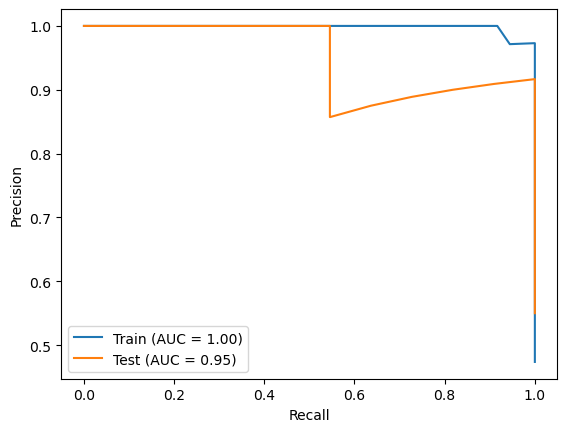

In [25]:
# Predict probabilities on the training and testing sets
y_train_proba = svc.predict_proba(X_train)[:, 1]
y_test_proba = svc.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## RF

In [26]:
RF= RandomForestClassifier(
    max_depth=50, 
    max_features='log2', 
    min_samples_split=5,
    n_estimators=50
)

RF.fit(X_train, y_train)
RF.score(X_test, y_test)

0.85

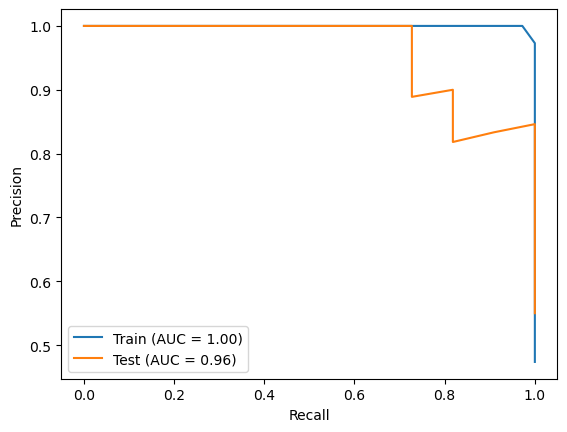

In [27]:
# Predict probabilities on the training and testing sets
y_train_proba = RF.predict_proba(X_train)[:, 1]
y_test_proba = RF.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## DecisionTreeClassifier

In [28]:
DT= DecisionTreeClassifier(
    max_depth=None, 
    min_samples_split=2
)

DT.fit(X_train, y_train)
DT.score(X_test, y_test)

0.85

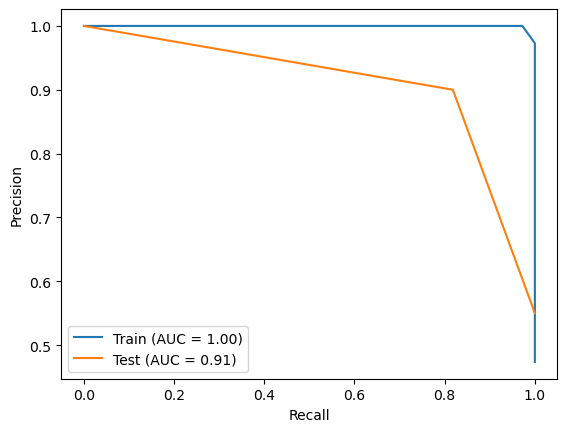

In [29]:
# Predict probabilities on the training and testing sets
y_train_proba = DT.predict_proba(X_train)[:, 1]
y_test_proba = DT.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Gaussian NB

In [59]:
results_df.iloc[2, 8]

"{'var_smoothing': 1e-09}"

In [10]:
gnb = GaussianNB(
    var_smoothing= 1e-09,
    )

gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.85

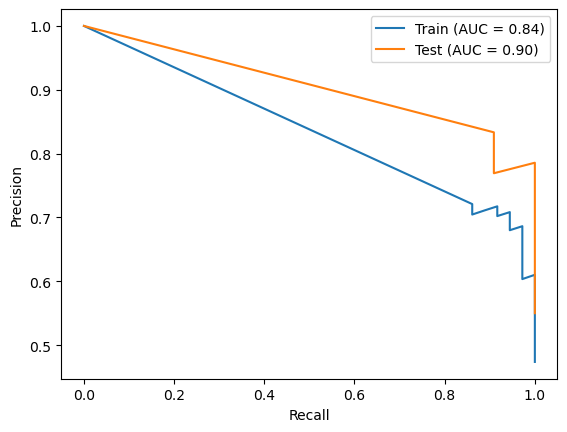

In [31]:
# Predict probabilities on the training and testing sets
y_train_proba = NB.predict_proba(X_train)[:, 1]
y_test_proba = NB.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## KNeighborsClassifier

In [33]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    p= 1,
    weights='distance')

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.65

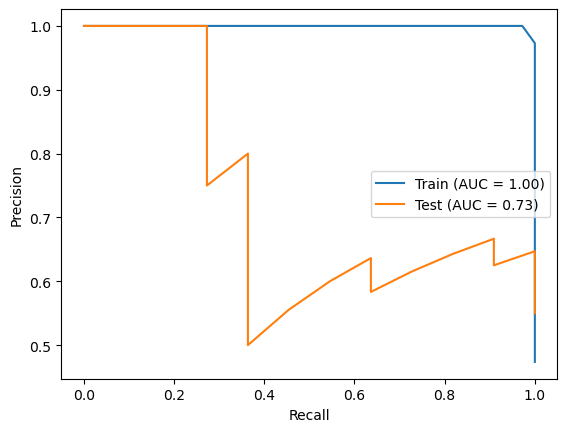

In [34]:
# Predict probabilities on the training and testing sets
y_train_proba = knn.predict_proba(X_train)[:, 1]
y_test_proba = knn.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## save the best model

In [61]:
#pickle.dump(gnb, open('model_GNB_esm2_15B_MBC_classification.pkl', 'wb'))
#pickle.dump(svc, open('model_SVC_esm2_15B_MBC_classification.pkl', 'wb'))